# Generalized Additive Models (GAM)

## 1. Explanation of Model

A generalized additive model (GAM) is a generalized linear model in which the linear predictor depends linearly on unknown smooth functions of some predictor variables, and interest focuses on inference about these smooth functions.

In [39]:
#General Imports
import pandas as pd
import numpy as np
import time
import random
import math
from collections import namedtuple, Counter
import scipy.stats as stats
from scipy.stats import norm
import datetime
from haversine import haversine, Unit

#Plotting/Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

#Modelling Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, silhouette_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from pygam import LogisticGAM

#Lets you view all columns in a dataframe when there are a LARGE number of columns
pd.set_option('display.max_columns', None)
#Fix for pandas truncating long strings (e.g. urls)
#If you don't run this, pandas will cut short your long urls and this breaks code that require urls
pd.set_option("display.max_colwidth", 10000)

In [3]:
df_combined = pd.read_csv(r'./datasets/clean_train_1.csv')
df_kag = pd.read_csv(r'./datasets/clean_test_1.csv')

In [4]:
df_combined.drop('Unnamed: 0', axis = 1, inplace = True)
df_kag.drop('Unnamed: 0', axis = 1, inplace = True)

## 2. Baseline Model

For our baseline model, we will be combining SMOTE with a logistic regression.

In [12]:
X = df_combined.drop(['WnvPresent', 'NumMosquitos', 'Date', 'Trap', 'Latitude', 'Longitude', 'Season',
                     'Year', 'Month'], axis = 1)
y = df_combined['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("X_train dataset: {}".format(X_train.shape))
print("y_train dataset: {}".format(y_train.shape))
print("X_test dataset: {}".format(X_test.shape))
print("y_test dataset: {}".format(y_test.shape))

X_train dataset: (6337, 44)
y_train dataset: (6337,)
X_test dataset: (2113, 44)
y_test dataset: (2113,)


In [14]:
print("Before SMOTE, counts of label '1': {}".format(sum(y_train==1)))
print("Before SMOTE, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After SMOTE, the shape of train_X: {}'.format(X_train_res.shape))
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After SMOTE, counts of label '1': {}".format(sum(y_train_res==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_res==0)))

Before SMOTE, counts of label '1': 343
Before SMOTE, counts of label '0': 5994 

After SMOTE, the shape of train_X: (11988, 44)
After SMOTE, the shape of train_y: (11988,) 

After SMOTE, counts of label '1': 5994
After SMOTE, counts of label '0': 5994


#### Applying the Logistic Regression

In [17]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=-1)
clf.fit(X_train_res, y_train_res.ravel())
clf.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   26.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.7s finished
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 10.0}

In [18]:
model_lr = LogisticRegression(C=10,verbose=5)
model_lr.fit(X_train_res, y_train_res.ravel())

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=5,
                   warm_start=False)

In [19]:
y_train_pre = model_lr.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric(train dataset): {}%".format(np.round(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1]), 2)))

Recall metric(train dataset): 80.17%


In [20]:
y_pre = model_lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric (testing dataset): {}%".format(np.round(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]), 2)))

Recall metric (testing dataset): 76.32%


C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

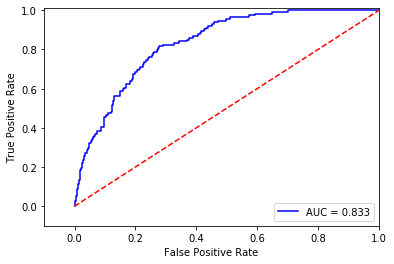

In [25]:
tmp = model_lr.fit(X_train_res, y_train_res.ravel())
y_pred_sample_score = tmp.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [116]:
X.columns

Index(['Tavg_x', 'PrecipTotal_x', 'is_sprayed', 'Station', 'Tavg_y', 'Depart',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA',
       'DZ', 'BR', 'HZ', 'humidity', 'Temp_diff', 'daylight_hours',
       'past_week_tavg', 'past_week_precip', 'past_week_humid',
       'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX'],
      dtype='object')

In [133]:
pd.DataFrame(sorted(zip(testnames, model_lr.coef_[0])), columns = ['feature', 'coef']).sort_values(by = 'coef').head(10)

,feature,coef
7,PrecipTotal_x,-36.181092
31,humidity,-8.371265
15,Species_CULEX TERRITANS,-5.255557
13,Species_CULEX SALINARIUS,-4.753338
10,Species_CULEX ERRATICUS,-3.584884
14,Species_CULEX TARSALIS,-2.104017
23,daylight_hours,-2.089021
4,Depart,-0.480403
34,past_3_precip,-0.415673
3,DZ,-0.402270


Text(0.5, 1.0, 'Logistic Regression Feature Importances')

<Figure size 1800x720 with 0 Axes>

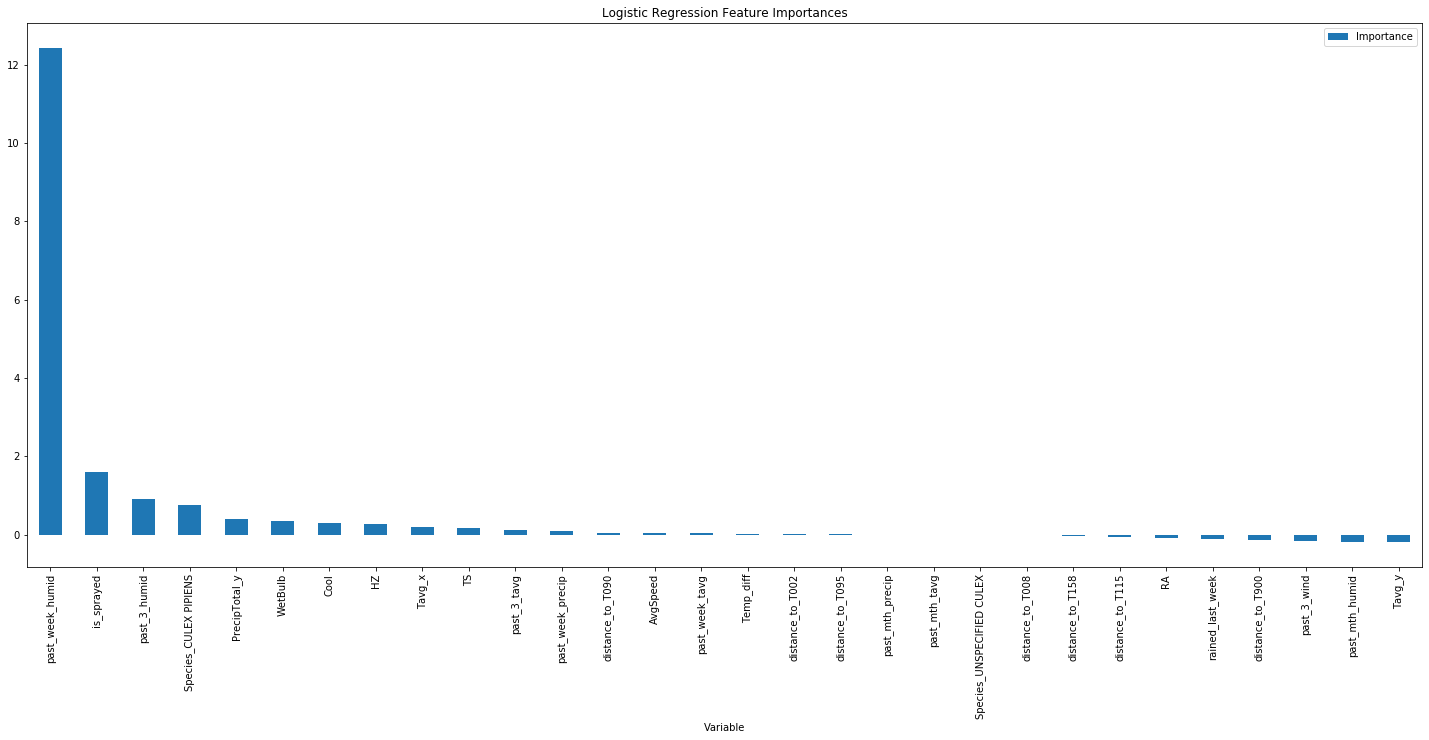

In [128]:
plt.figure(figsize = (25, 10))
testnames = X.columns.tolist()
xg_importances = pd.DataFrame(sorted(zip(testnames, model_lr.coef_[0]), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')
xg_importances.sort_values(by = 'Importance', ascending = False).iloc[:30,:].plot(kind = 'bar', figsize =(25,10))
plt.title('Logistic Regression Feature Importances')

The logistic regression performs fairly well, with an AUC of 0.833 and a strong recall score (i.e. True Positives over Condition Positives). Recall from our problem statement that recall is an important metric for our model, since we want to be able to capture as many of the WNV outbreaks as possible, while balancing it against a strong AUC score, so that we do not over-predict WNV and waste city resources of excessive spraying.

## 3. Customized Train Test Splits (By Year, Target)

Here, we will generate multiple train test splits to generate variations of the train and test set based on the number of years. This allows us to test if our model generalizes well to a certain year, or the option to bag or stack models based on individual years.

In [31]:
'''
This function fits a KNN to the train set, and predicts it on the test (kaggle) set with n_neighbors = 1 and weights
set to distance to attach the point to its nearest neighbor.

The if functions differentiates between clustering with NumMosquitos as a feature, and clustering without NumMosquitos.
The key word 'mosq' must be in the cluster name for the function to work.
'''



def classify_clusters(df_main, df_class, clusters):
    df_test_clf = df_class
    knn = KNeighborsClassifier(n_neighbors = 1, weights = 'distance')
    
    for cluster in clusters:
        #Include num mosquitos in clustering
        if 'mosq' in cluster:
            knn.fit(df_main[['Latitude', 'Longitude', 'NumMosquitos']], df_main[cluster])
            geo_clusters = knn.predict(df_class[['Latitude', 'Longitude', 'NumMosquitos']])
            df_test_clf[cluster] = geo_clusters
            
        #Exclude num mosquitos in clustering (lat long only)
        else:
            knn.fit(df_main[['Latitude', 'Longitude']], df_main[cluster])
            geo_clusters = knn.predict(df_class[['Latitude', 'Longitude']])
            df_test_clf[cluster] = geo_clusters        
    
    return df_test_clf

In [32]:
'''
This function does the following:
1) Loops through a dictionary to find what variations of the train test split should be made. 
Refer to X_dict for an example.

2) Call the classify_clusters function to find class labels on the test/kaggle set

3) Gets dummies based on a specified feature list (this is to enable quick dropping of features while modelling)

4) Runs a try/except to drop all unwanted features based on a feature list (to enable quick feature selection)

5) Checks if the train set and kaggle set features tally, and adds empty columns or drops columns in the kaggle set
if needed.

6) Rearranges the column order so the train and kaggle data sets are aligned (since XGBoost gets cranky otherwise)

'''

def split_datasets(X, y, Xtrain, ytrain, Xtest, ytest, metadict, dummy_features, features_to_drop, clusters = None):
    
    #Loop through dictionary to get dataframe variations
    #Also gets dummies based on dummy_features list
    for i in X.keys():
        
        #Drop clusters from unwanted features list
        #Predicts clusters in kaggle set if clusters is not none
        if clusters != None:
            unwanted_features = [item for item in features_to_drop if item not in clusters]
            metadict[i] = classify_clusters(df_combined, df_kag, clusters)
        else:
            unwanted_features = features_to_drop
        
        try: #If we can stratify y (i.e. binary task)
            Xtrain[i], Xtest[i], ytrain[i], ytest[i] = train_test_split(
                pd.get_dummies(X[i], columns = dummy_features), y[i], test_size = 0.3, stratify = y[i])
            
        except: #Can't stratify y (i.e. regression task, too few values of y)
            print('Could not stratify y!')
            Xtrain[i], Xtest[i], ytrain[i], ytest[i] = train_test_split(
                pd.get_dummies(X[i], columns = dummy_features), y[i], test_size = 0.3)    
        
        #Create a new meta test set (the kaggle set) with features that correspond to train
        #Gets dummies, and drops the Id column which doesn't exist in the train set
        metadict[i] = df_kag
        metadict[i] = pd.get_dummies(metadict[i], columns = dummy_features)
        metadict[i].drop('Id', axis = 1, inplace = True)
        
        #Tries to drop features in unwanted_features list if it's there
        for feature in unwanted_features:
            try:
                Xtrain[i].drop(feature, axis = 1, inplace = True)
                Xtest[i].drop(feature, axis = 1, inplace = True)
            except:
                print('{} could not be dropped from X because it doesn\'t exist!'.format(feature))
                
            try:
                metadict[i].drop(feature, axis = 1, inplace = True)
            except:
                print('{} could not be dropped from metadict because it doesn\'t exist!'.format(feature))                
                               

        #Check if features tally
        to_remove = [col for col in metadict[i].columns if col not in Xtrain[i].columns]
        to_add = [col for col in Xtrain[i].columns if col not in metadict[i].columns]
        print('{} removed from meta dataframe {}'.format(to_remove, i))
        print('{} added to meta dataframe {}'.format(to_add, i))
        
        #If there are features that don't match, add or remove them.
        if to_remove != []:
            for remove in to_remove:
                metadict[i].drop(remove, axis = 1, inplace = True)

        if to_add != []:
            for add in to_add:
                metadict[i][add] = 0
                
        #Set order of columns to be equal
        metadict[i] = metadict[i][list(Xtrain[i].columns)]

In [35]:
# Dictionaries for creating different datasets in Train Test Split
#For WNV
X_dict = {
    0: df_combined,
    1: df_combined[df_combined['Year']==2007],
    2: df_combined[df_combined['Year']==2009],
    3: df_combined[df_combined['Year']==2011],
    4: df_combined[df_combined['Year']==2013]
    
}

#For WNV
y_dict = {
    0: df_combined['WnvPresent'],
    1: df_combined[df_combined['Year']==2007]['WnvPresent'],
    2: df_combined[df_combined['Year']==2009]['WnvPresent'],
    3: df_combined[df_combined['Year']==2011]['WnvPresent'],
    4: df_combined[df_combined['Year']==2013]['WnvPresent']
    
}

In [37]:
# Test Train Splits by Year

features_to_drop =['WnvPresent', 'NumMosquitos', 'is_sprayed', 'Season','Month', 'WetBulb', 'Date', 'Trap', 'Latitude', 
                   'Longitude', 'kmeans_geog_clusters', 'Year', 'Station', 'kmeans_mosq_clusters', 
                   'dbscan_geog_clusters', 'dbscan_mosq_clusters', 'meanshift_wnv_clusters', 'meanshift_mosq_clusters']
#clusters must be a list
clusters = None
#dummy_features must be a list    
dummy_features =  []



meta_dict = {}

X_train = {}
y_train = {}
X_test = {}
y_test = {}

split_datasets(X_dict, y_dict, X_train, y_train, X_test, y_test, meta_dict, dummy_features,
               features_to_drop, clusters = clusters)

WnvPresent could not be dropped from metadict because it doesn't exist!
NumMosquitos could not be dropped from metadict because it doesn't exist!
kmeans_geog_clusters could not be dropped from X because it doesn't exist!
kmeans_geog_clusters could not be dropped from metadict because it doesn't exist!
kmeans_mosq_clusters could not be dropped from X because it doesn't exist!
kmeans_mosq_clusters could not be dropped from metadict because it doesn't exist!
dbscan_geog_clusters could not be dropped from X because it doesn't exist!
dbscan_geog_clusters could not be dropped from metadict because it doesn't exist!
dbscan_mosq_clusters could not be dropped from X because it doesn't exist!
dbscan_mosq_clusters could not be dropped from metadict because it doesn't exist!
meanshift_wnv_clusters could not be dropped from X because it doesn't exist!
meanshift_wnv_clusters could not be dropped from metadict because it doesn't exist!
meanshift_mosq_clusters could not be dropped from X because it do

## 4. Modelling

In [33]:
#Finds true positive rate
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [45]:
def plot_roc_curve(df):
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 200)
    
    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
#     plt.title('Receiver Operating Characteristic Curve', fontsize=22)
#     plt.ylabel('Sensitivity', fontsize=18)
#     plt.xlabel('1 - Specificity', fontsize=18)
    
    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(df["true_values"], df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [41]:
sc = StandardScaler()
log_gam = LogisticGAM(n_splines=20).gridsearch(sc.fit_transform(X_train[0]), y_train[0])

gam_results = log_gam.predict_proba(sc.fit_transform(meta_dict[0]))
print('Accuracy Score {}'.format(log_gam.accuracy(sc.fit_transform(X_test[0]), y_test[0])))

sub_df = pd.DataFrame(list(gam_results), index = df_kag['Id'], columns = ['WnvPresent'])
sub_df.to_csv('gam_1.csv')

100% (11 of 11) |########################| Elapsed Time: 0:04:08 Time:  0:04:08


In [72]:
log_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      48.233
Link Function:                        LogitLink Log Likelihood:                                  -940.5436
Number of Samples:                         5915 AIC:                                             1977.5532
                                                AICc:                                            1978.3965
                                                UBRE:                                               2.3409
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2443
Feature Function                  Lam

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [43]:
print('Accuracy Score {}'.format(log_gam.accuracy(sc.fit_transform(X_test[0]), y_test[0])))

Accuracy Score 0.9447731755424064


True Negatives: 2393
False Positives: 5
False Negatives: 135
True Positives: 2


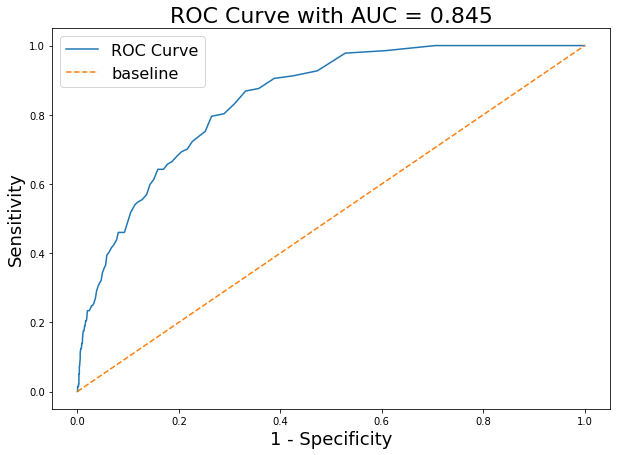

In [53]:
pred_proba = log_gam.predict_proba(sc.fit_transform(X_test[0]))
pred_df = pd.DataFrame({'true_values': y_test[0],
                        'pred_probs': pred_proba})
predictions = log_gam.predict(sc.fit_transform(X_test[0]))
tn, fp, fn, tp = confusion_matrix(y_test[0], predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

    
plot_roc_curve(pred_df)

In [44]:
X_train[0].columns

Index(['Tavg_x', 'PrecipTotal_x', 'Tavg_y', 'Depart', 'Heat', 'Cool',
       'PrecipTotal_y', 'AvgSpeed', 'TS', 'RA', 'DZ', 'BR', 'HZ', 'humidity',
       'Temp_diff', 'daylight_hours', 'past_week_tavg', 'past_week_precip',
       'past_week_humid', 'past_mth_tavg', 'past_mth_precip', 'past_mth_humid',
       'rained_last_week', 'past_3_tavg', 'past_3_precip', 'past_3_humid',
       'past_3_wind', 'distance_to_T900', 'distance_to_T002',
       'distance_to_T008', 'distance_to_T115', 'distance_to_T090',
       'distance_to_T095', 'distance_to_T158', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX'],
      dtype='object')

The GAM with the above set of features was the best performing model, with a Kaggle Private Score of 0.79185 and a Public Score of 0.80078. 
A concern with this model, however, is the poor recall score. Out of 137 cases of WNV, it only predicted 2.

We will now investigate the features of the model.



## 5. Visualizing Features

One of the nice things about GAMs is that their additive nature allows us to explore and interpret individual features by holding others at their mean.

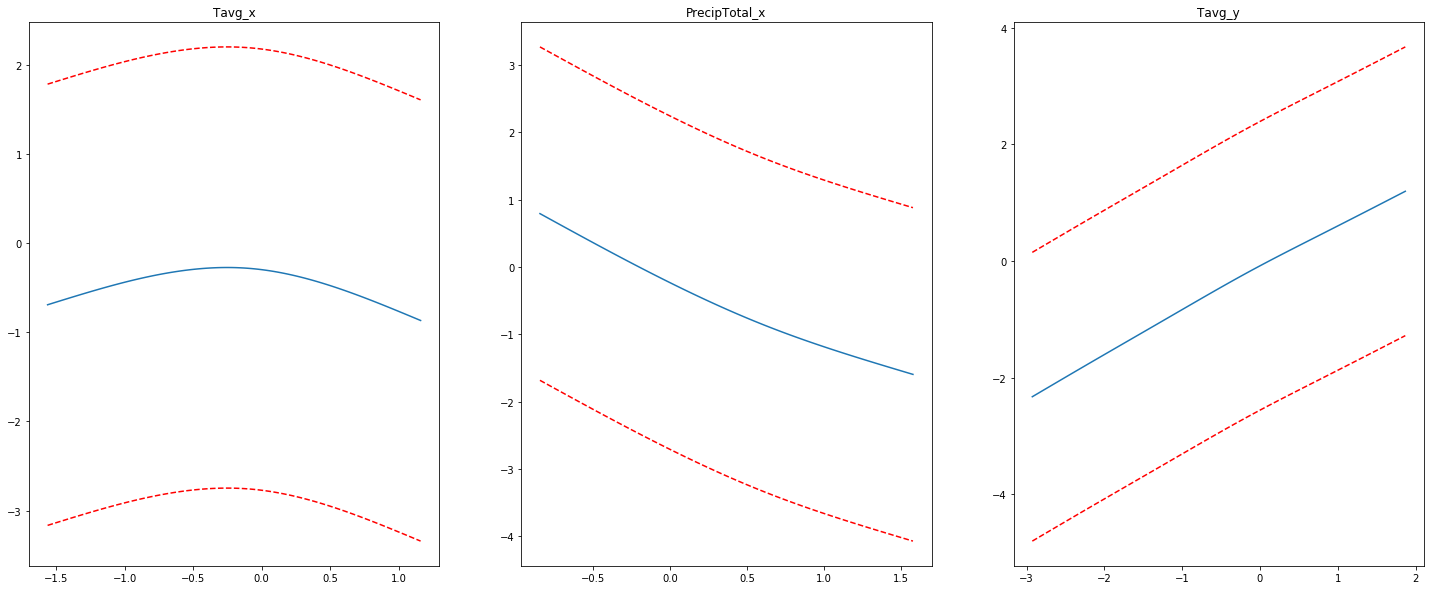

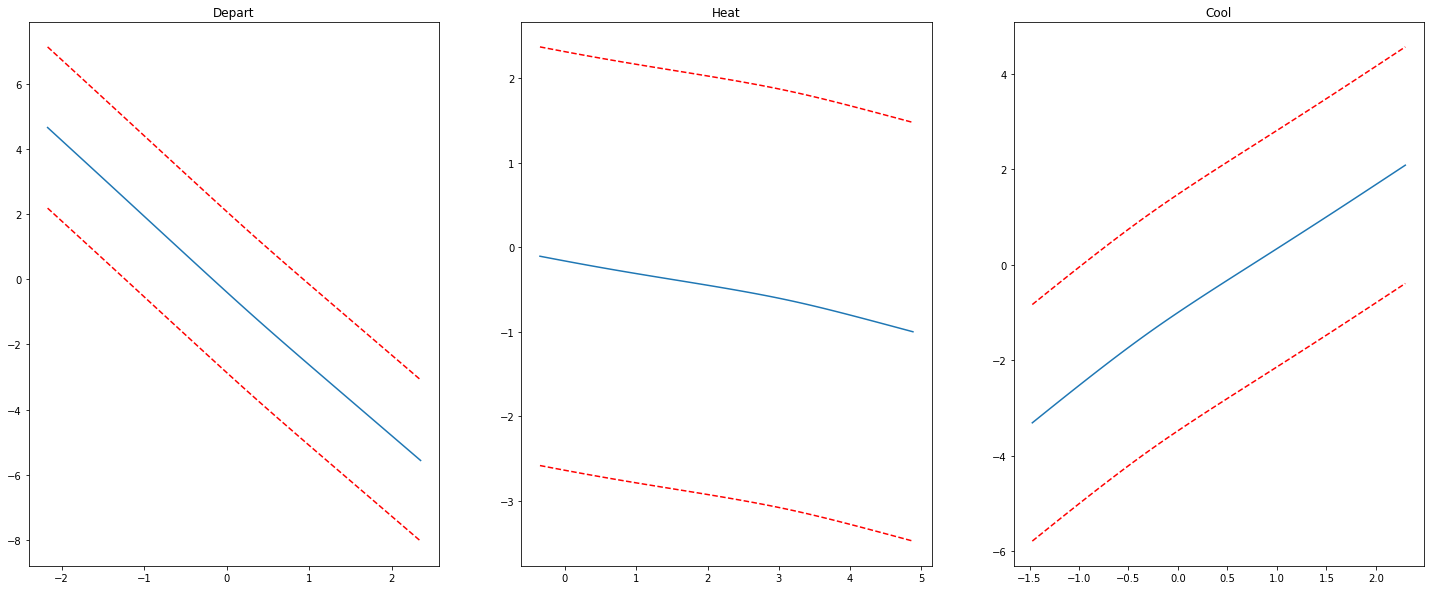

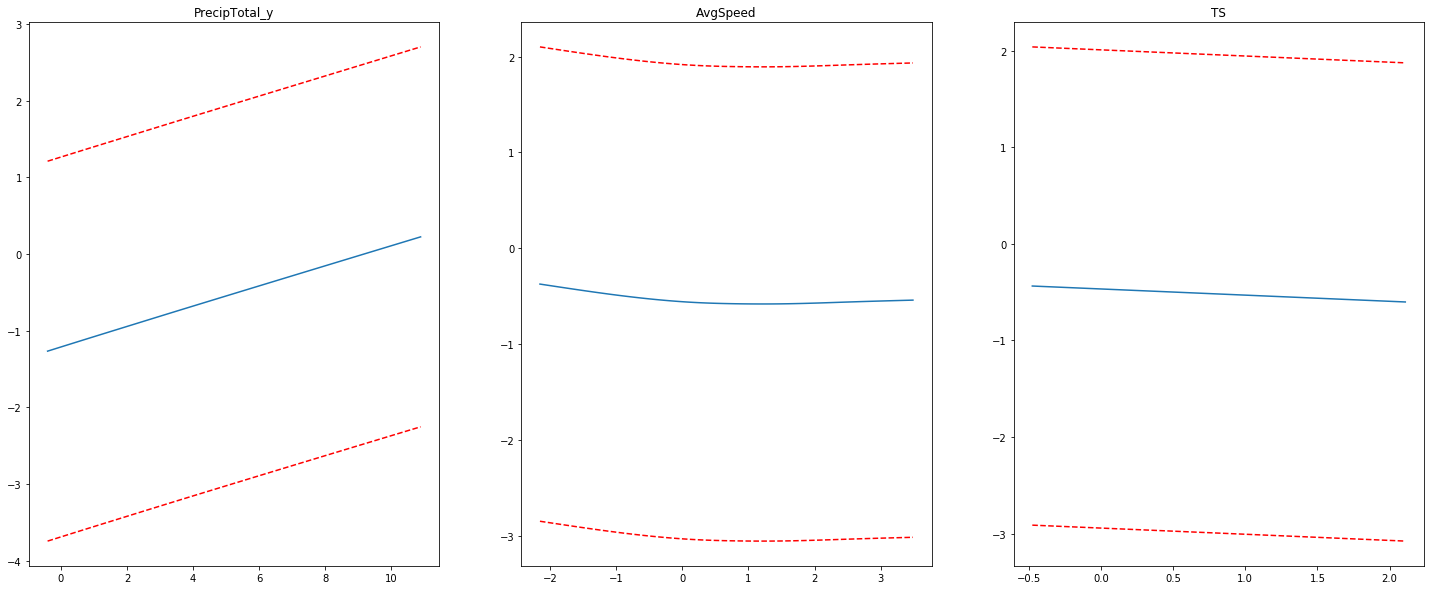

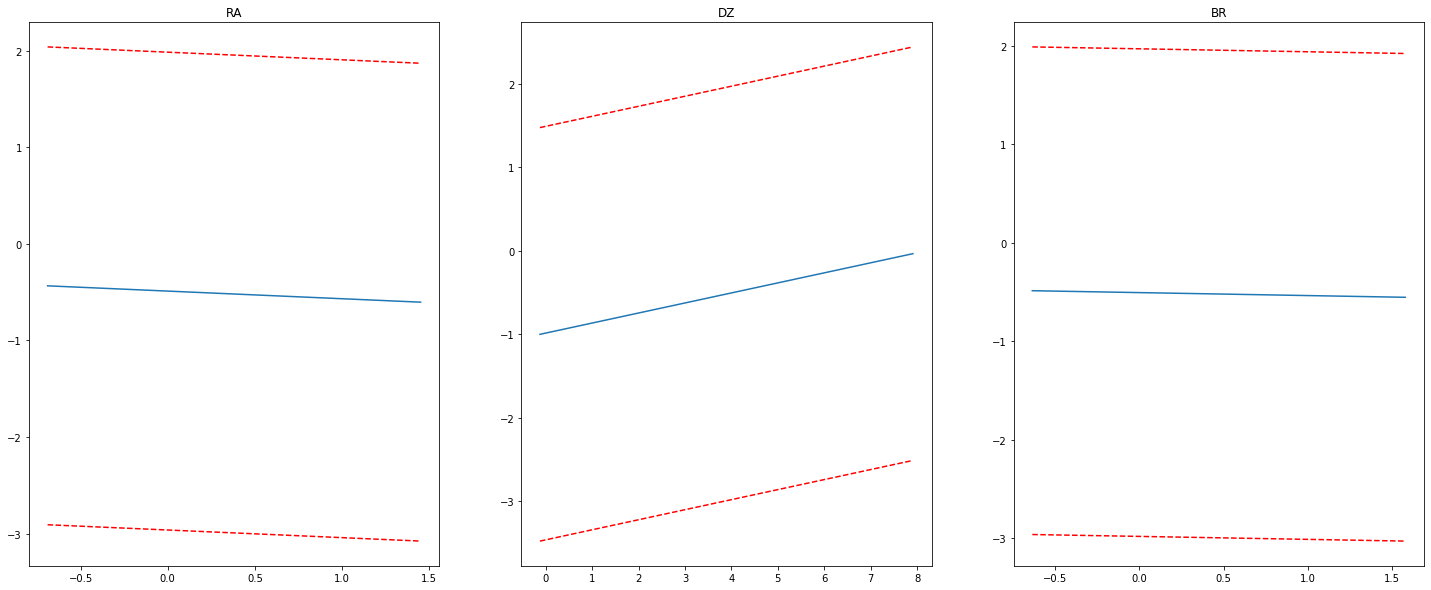

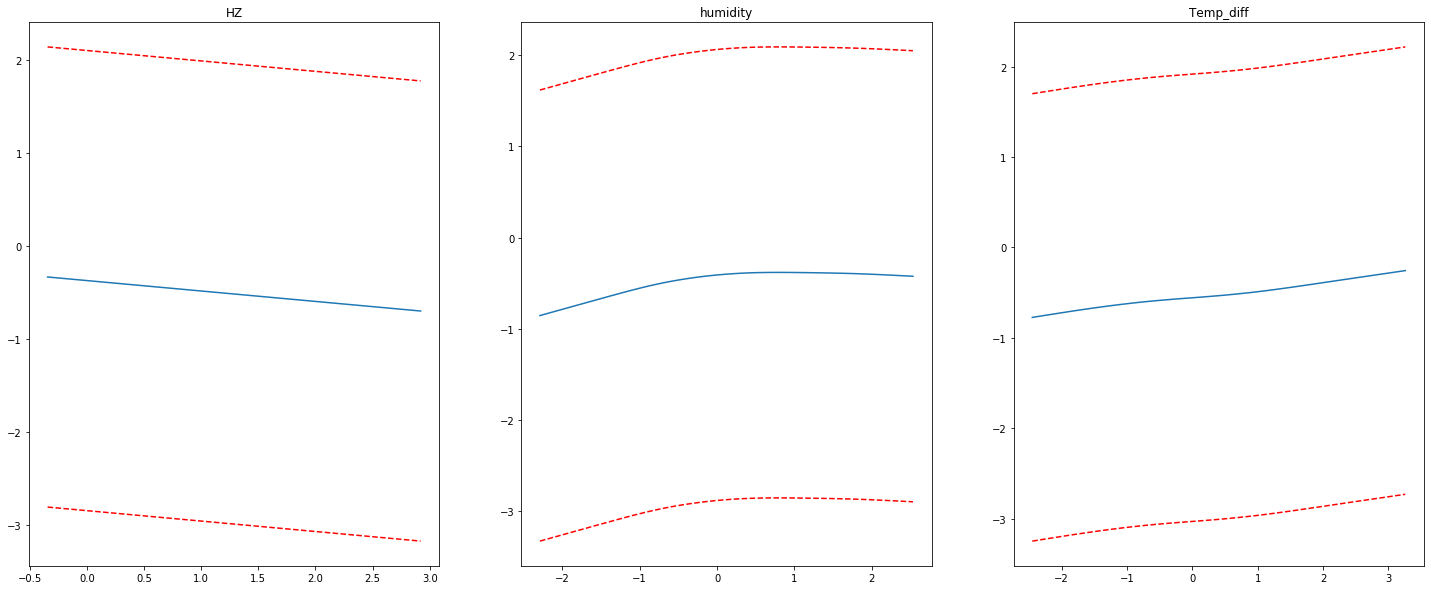

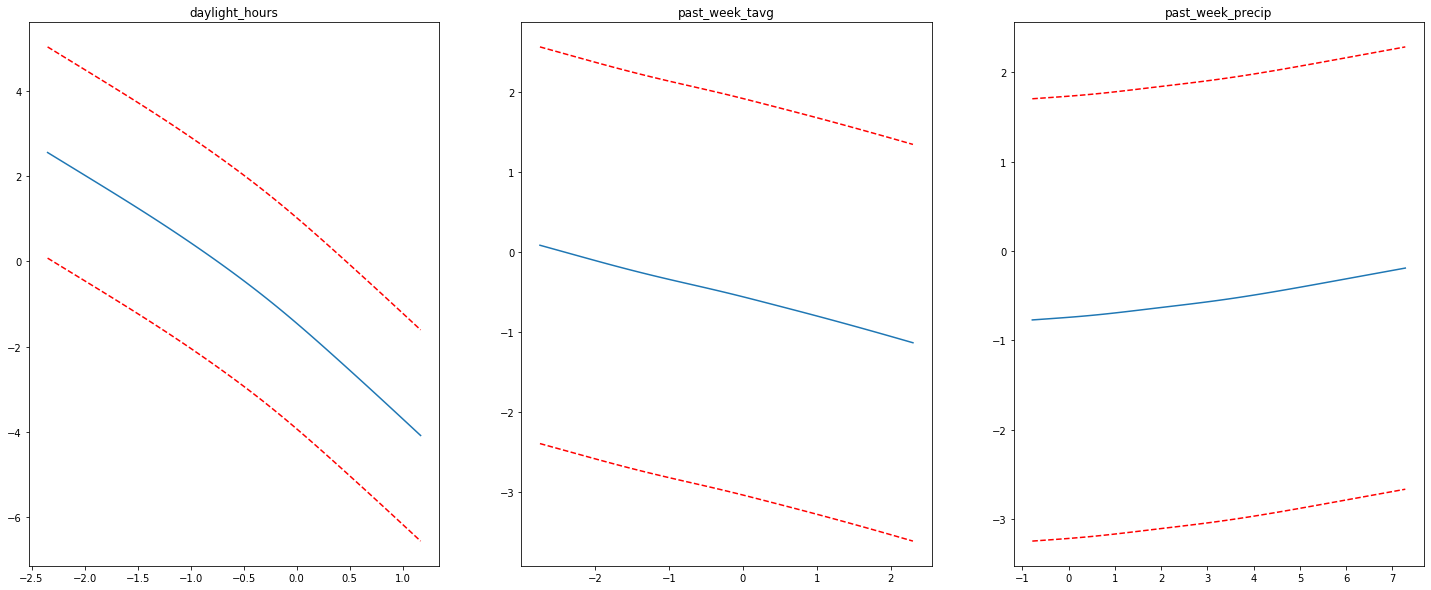

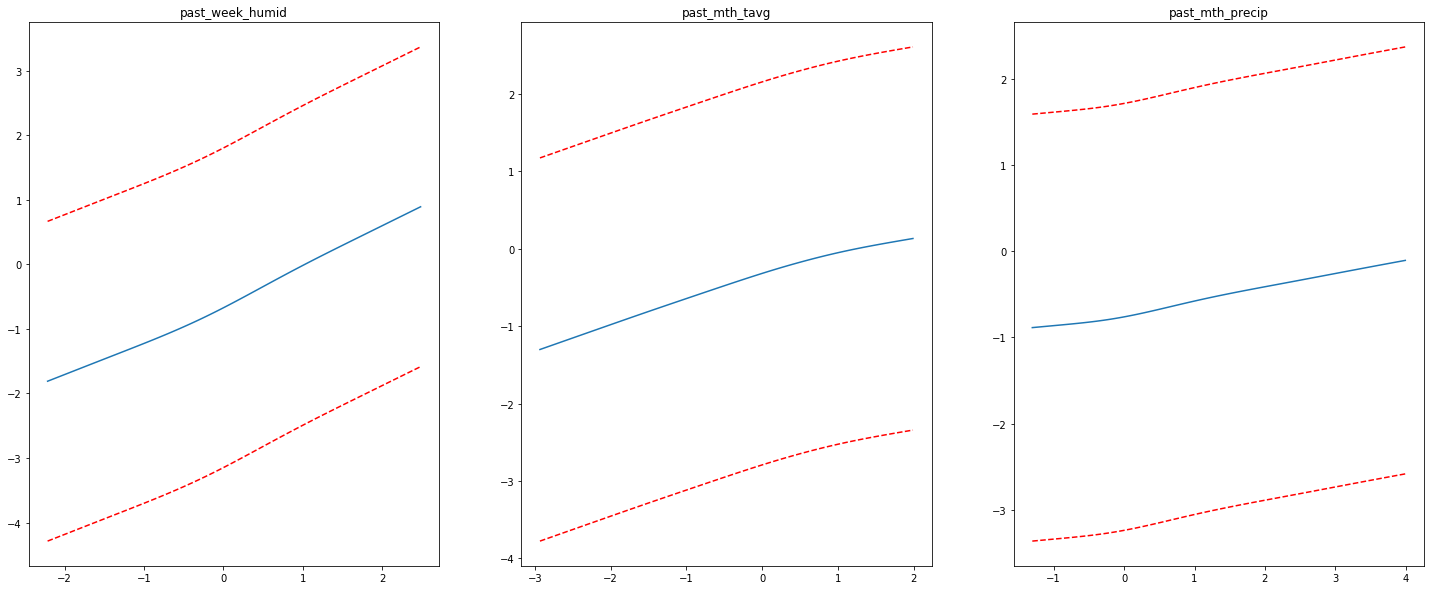

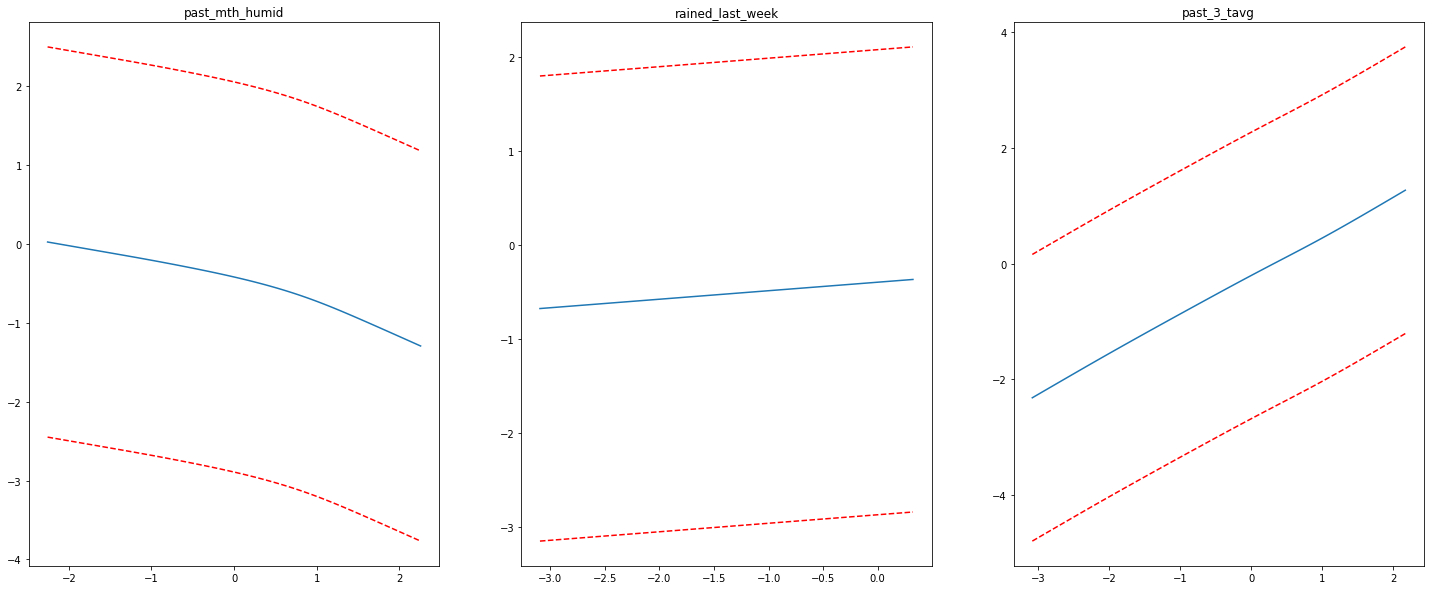

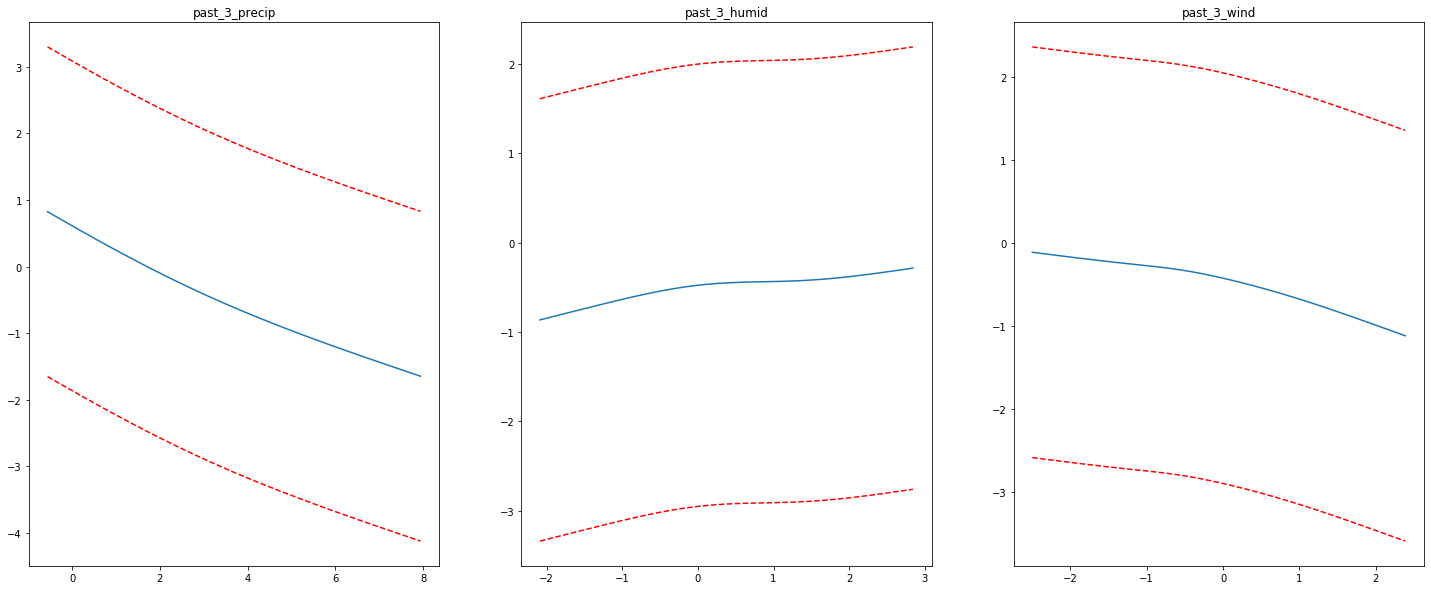

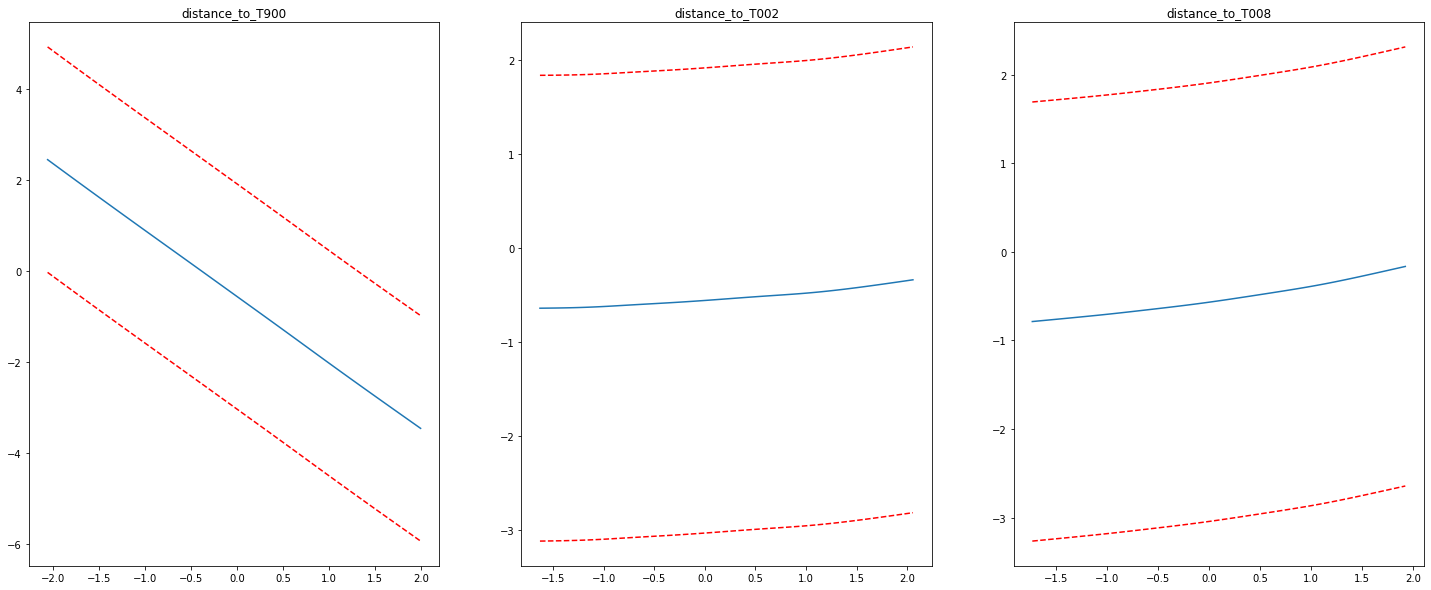

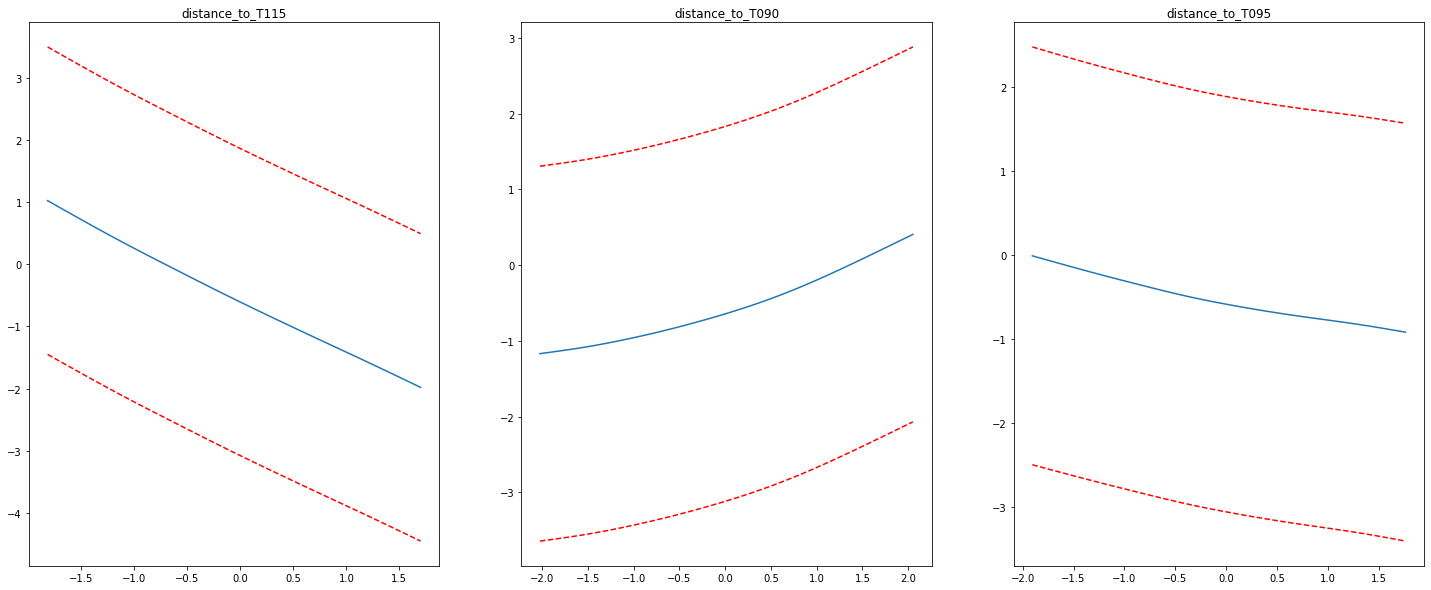

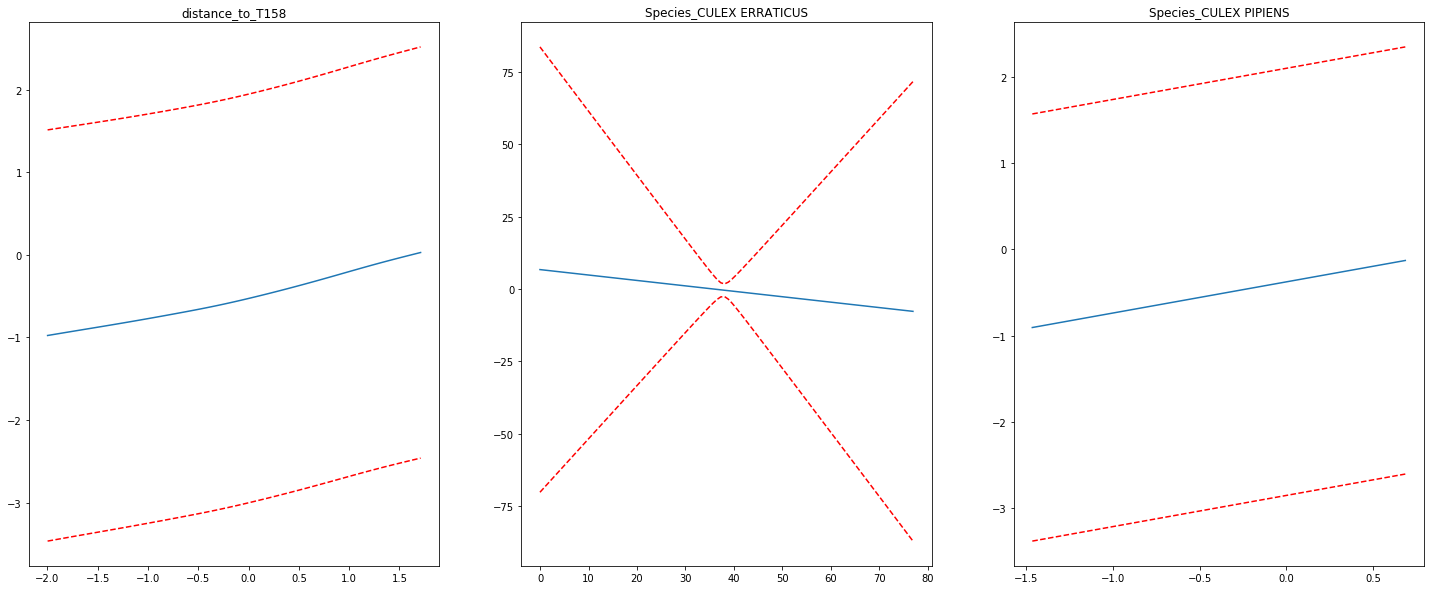

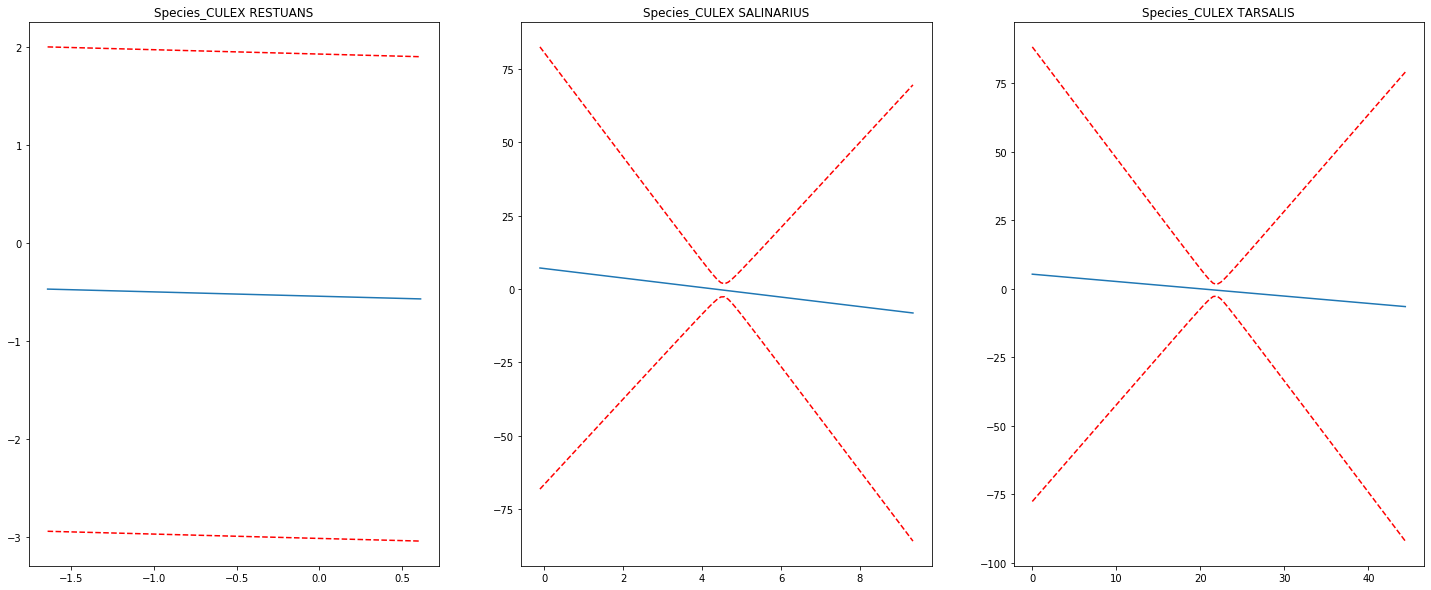

In [107]:
i = 0
for n in range(0, int(len(X_train[0].columns)/3)):
    fig, axs = plt.subplots(1, 3, figsize = (25, 10))
    titles = X_train[0].columns

    for ax in axs:
        XX = log_gam.generate_X_grid(term=i)
        pdep, confi = log_gam.partial_dependence(term=i, width=.1)

        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(titles[i]);
        i += 1

The graphs above can be interpreted as such:
- The blue line represents the feature's relationship with the target variable (WNV), with all other variables held constant.
- The red lines represent confidence intervals - the further the spread, the higher the variance.

Whilst most of the relationships are linear, it is interesting to note that humidity and spot day temperature (Tavg_x) curve: as day temperature goes past a certain point, it seems less likely that WNV is found in mosquitos.

The gradient of the blue line represents the strength of the relationship. The temperature variables tend to be the strongest predictors, yearly and past 3 days' temperature being exceptionally strong features.

## 6. Summary of Model

The GAM model performs exceptionally well in terms of generalizing its AUC/ROC score, but falls short in terms of it's recall score.

As a whole we propose combining multiple models to enjoy the best of both worlds. This model is, however, useful in helping us visualize the features critical to controlling WNV (temperature and weather trends).